**策略名称：** 创业板动量策略

**策略简介:** 动量交易是通过分析近期价格趋势的强弱来买卖金融资产的策略，创业板动量策略使用创业板一个月的涨幅作为交易信号，如果涨幅大于8%，则买入，如果涨幅小于0,则卖出。

**策略表现：**夏普值1.1, 最大回撤18%，年化回报20%

**代码作者：** Spectator

**结构说明：**

第一部分: 安装并导入依赖包;
第二部分：加载数据;
第三部分： 计算动量信号，作为策略信号进行回测;


# 第一部分: 安装并导入依赖包

**1. 安装依赖包**

In [ ]:
!pip install akshare quantstats

**2.导入依赖包**

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import time
import akshare as ak
import numpy as np
import pandas as pd
import quantstats as qs


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

# 第二部分：加载数据

<Axes: xlabel='date'>

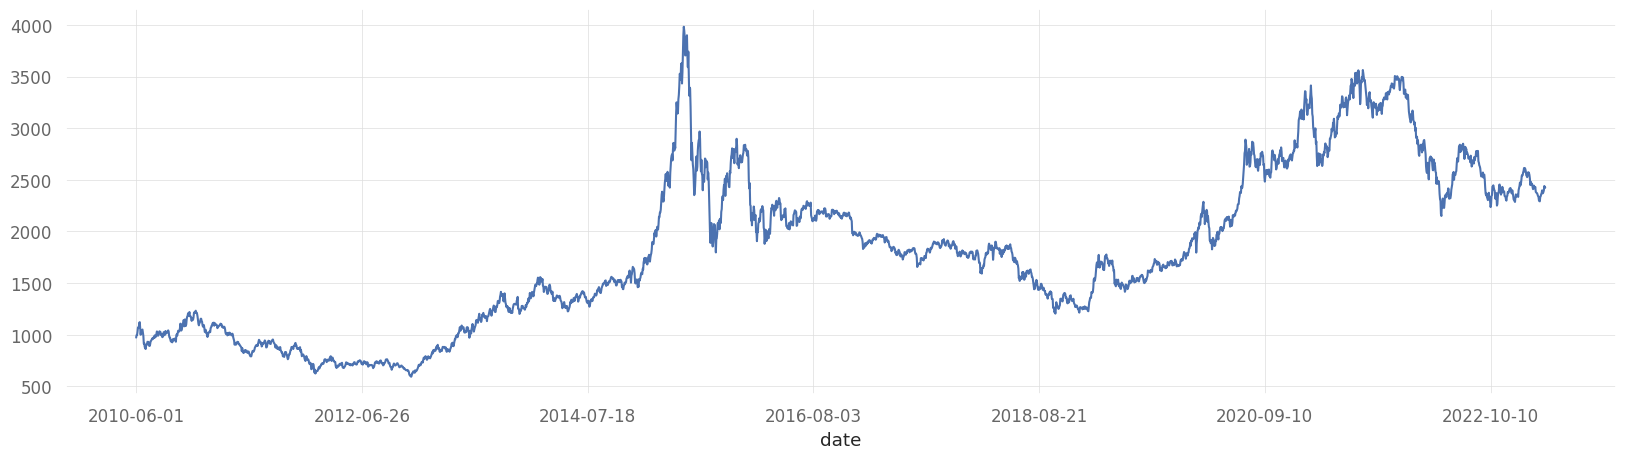

In [ ]:
cyb = ak.stock_zh_index_daily(symbol="sz399006")
cyb = cyb.set_index("date")
cyb.index = cyb.index.astype(str)
cyb["close"].plot(figsize=(20,5))

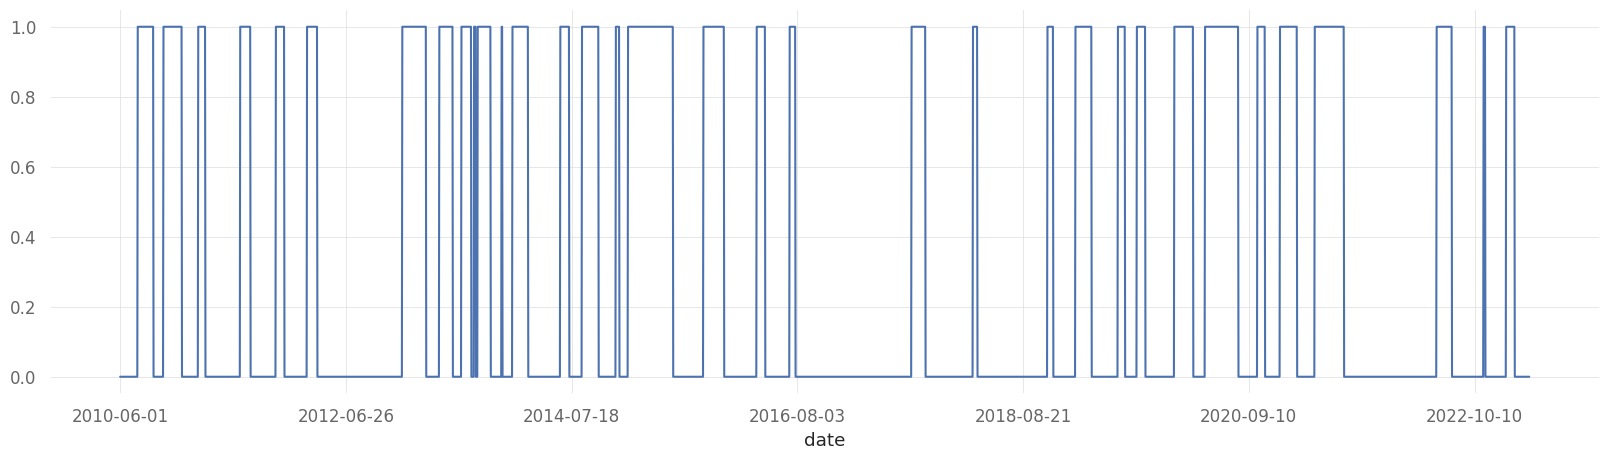

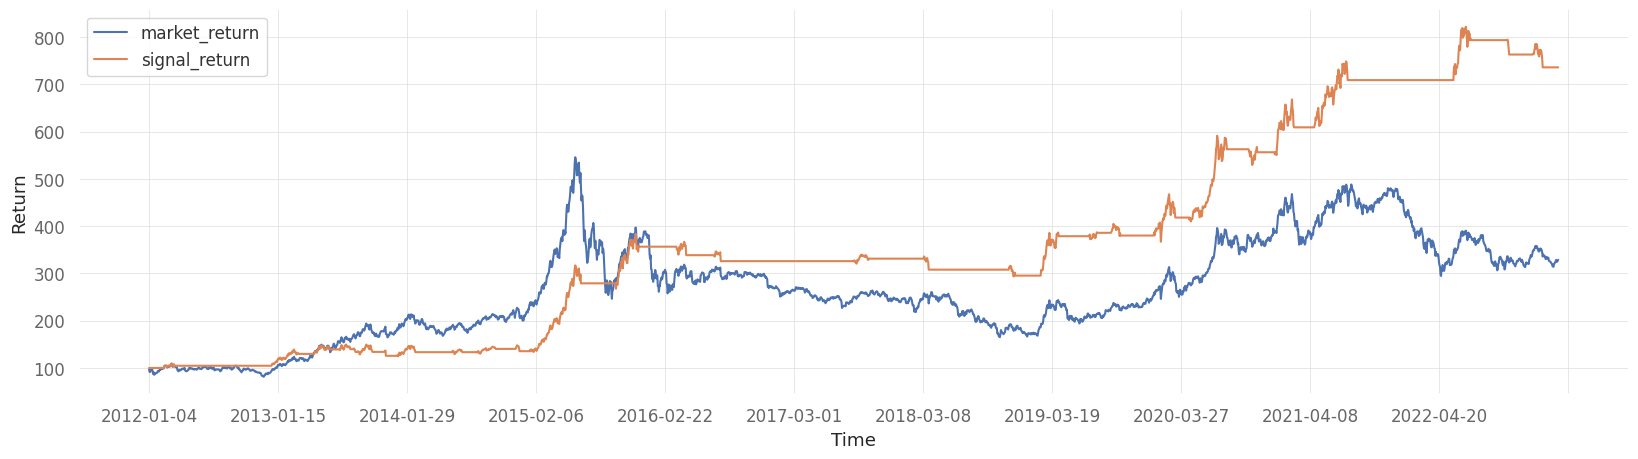

In [ ]:
# 计算动量信号
def signal(x):
    if x > 0.08:
        return 1
    if x < 0:
        return 0
    return np.nan

window = 21
cyb["day_return"] = cyb.close.rolling(2).apply(lambda x:(x[-1]-x[0])/x[0])
cyb["pct_chg"]=cyb.close.rolling(window).apply(lambda x: (x[-2]-x[0])/x[0])
cyb["signal"]= cyb.apply(lambda row: signal(row["pct_chg"]), axis=1)
cyb["signal"] = cyb["signal"].fillna(method='ffill').fillna(0)
cyb['change_position'] = cyb['signal'].rolling(2).apply(lambda x:x[0]!=x[1])

cyb["signal"].plot(figsize=(20,5))

# 回测分析
backtest_data = cyb.loc['2012-01-01':'2023-03-31']
backtest_data["market_return"] = np.cumprod(backtest_data.day_return.values + 1) *100
backtest_data["signal_return"] = np.cumprod((backtest_data["signal"].values * backtest_data.day_return.values + 1)*(1-0*backtest_data['change_position'])) * 100

_ = plt.figure(figsize=(20, 5))
plt.xlabel('Time') 
plt.ylabel('Return')
_ = plt.plot(backtest_data["market_return"].index,backtest_data["market_return"].values)
_ = plt.plot(backtest_data["signal_return"].index,backtest_data["signal_return"].values)
_ = plt.legend(['market_return', 'signal_return', ]) 

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(250))

# 计算策略表现指标
result = {}
for i in ["market_return", "signal_return"]:
    result[i] = []
    for j in ["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"]:
        exec( f"r = qs.stats.{j}(backtest_data[i])")
        result[i].append(r)

result = pd.DataFrame(result, index=["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"])
